In [39]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
 
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
 
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
# Define labels for the target variable
LABELS = ["Show", "No Show"]
 

In [40]:
data = pd.read_csv('raw_data.csv')

In [41]:
data.head(2)

,Gender,Age,Alcohol_Consumption,Hypertension,Diabetes,Appointment_Date,Schedule_Date,Clinic_Location,Specialty,Neighborhood,target_no_show
0,F,43,5/week,False,False,2021-01-14 10:30:00,2020-10-26,Mission Bay,Human Performance Center,Russian Hill,False
1,F,43,5/week,False,False,2021-01-14 10:30:00,2020-10-26,Mission Bay,Human Performance Center,Russian Hill,False


In [42]:
print(data.dtypes)

Gender                 object
Age                     int64
Alcohol_Consumption    object
Hypertension             bool
Diabetes                 bool
Appointment_Date       object
Schedule_Date          object
Clinic_Location        object
Specialty              object
Neighborhood           object
target_no_show           bool
dtype: object


In [43]:
# Create age group categories and convert to one-hot encoding
data['age_group'] = pd.cut(data['Age'], bins=[0, 30, 40, 50, 60, 100], labels=['<30', '30-40', '40-50', '50-60', '>60'])
data = pd.get_dummies(data, columns=['age_group'], drop_first=True)

In [44]:
data.head(2)

,Gender,Age,Alcohol_Consumption,Hypertension,Diabetes,Appointment_Date,Schedule_Date,Clinic_Location,Specialty,Neighborhood,target_no_show,age_group_30-40,age_group_40-50,age_group_50-60,age_group_>60
0,F,43,5/week,False,False,2021-01-14 10:30:00,2020-10-26,Mission Bay,Human Performance Center,Russian Hill,False,False,True,False,False
1,F,43,5/week,False,False,2021-01-14 10:30:00,2020-10-26,Mission Bay,Human Performance Center,Russian Hill,False,False,True,False,False


In [45]:
data.drop('Age',axis='columns',inplace=True)

In [46]:
data.head(2)

,Gender,Alcohol_Consumption,Hypertension,Diabetes,Appointment_Date,Schedule_Date,Clinic_Location,Specialty,Neighborhood,target_no_show,age_group_30-40,age_group_40-50,age_group_50-60,age_group_>60
0,F,5/week,False,False,2021-01-14 10:30:00,2020-10-26,Mission Bay,Human Performance Center,Russian Hill,False,False,True,False,False
1,F,5/week,False,False,2021-01-14 10:30:00,2020-10-26,Mission Bay,Human Performance Center,Russian Hill,False,False,True,False,False


In [47]:
# Map 'Alcohol Consumption' to numeric values
mapping_dict = {'0/week': 0, '1/week': 1, '5/week': 2, '10/week': 3, '> 14/week': 4}
data['Alcohol_Consumption'] = data['Alcohol_Consumption'].map(mapping_dict)


In [48]:
data.head(2)

,Gender,Alcohol_Consumption,Hypertension,Diabetes,Appointment_Date,Schedule_Date,Clinic_Location,Specialty,Neighborhood,target_no_show,age_group_30-40,age_group_40-50,age_group_50-60,age_group_>60
0,F,2,False,False,2021-01-14 10:30:00,2020-10-26,Mission Bay,Human Performance Center,Russian Hill,False,False,True,False,False
1,F,2,False,False,2021-01-14 10:30:00,2020-10-26,Mission Bay,Human Performance Center,Russian Hill,False,False,True,False,False


In [49]:
# Convert 'Hypertension' and 'Diabetes' to integer
data['Hypertension'] = data['Hypertension'].astype(int)
data['Diabetes'] = data['Diabetes'].astype(int)

In [50]:
# Convert 'target_no_show' to integer
data['target_no_show'] = data['target_no_show'].astype(int)

In [51]:
# Convert date columns to datetime format and extract features
data['Appointment_Date'] = pd.to_datetime(data['Appointment_Date'])
data['Schedule_Date'] = pd.to_datetime(data['Schedule_Date'])
data['appointment_day'] = data['Appointment_Date'].dt.day
data['appointment_month'] = data['Appointment_Date'].dt.month
data['appointment_year'] = data['Appointment_Date'].dt.year
data['appointment_dayofweek'] = data['Appointment_Date'].dt.dayofweek
data['schedule_day'] = data['Schedule_Date'].dt.day
data['schedule_month'] = data['Schedule_Date'].dt.month
data['schedule_year'] = data['Schedule_Date'].dt.year
data['schedule_dayofweek'] = data['Schedule_Date'].dt.dayofweek
data['days_until_appointment'] = (data['Appointment_Date'] - data['Schedule_Date']).dt.days
 
# Drop the original date columns if they are not needed anymore
data.drop(columns=['Appointment_Date', 'Schedule_Date'], inplace=True)

In [52]:
data.head(2)

,Gender,Alcohol_Consumption,Hypertension,Diabetes,Clinic_Location,Specialty,Neighborhood,target_no_show,age_group_30-40,age_group_40-50,...,age_group_>60,appointment_day,appointment_month,appointment_year,appointment_dayofweek,schedule_day,schedule_month,schedule_year,schedule_dayofweek,days_until_appointment
0,F,2,0,0,Mission Bay,Human Performance Center,Russian Hill,0,False,True,...,False,14,1,2021,3,26,10,2020,0,80
1,F,2,0,0,Mission Bay,Human Performance Center,Russian Hill,0,False,True,...,False,14,1,2021,3,26,10,2020,0,80


In [53]:
# Apply One-Hot Encoding for nominal variables
data = pd.get_dummies(data, columns=['Clinic_Location', 'Specialty', 'Neighborhood'])

In [54]:
data.head(2)

,Gender,Alcohol_Consumption,Hypertension,Diabetes,target_no_show,age_group_30-40,age_group_40-50,age_group_50-60,age_group_>60,appointment_day,...,Neighborhood_Presidio,Neighborhood_Presidio Heights,Neighborhood_Russian Hill,Neighborhood_Seacliff,Neighborhood_South of Market,Neighborhood_Treasure Island/YBI,Neighborhood_Twin Peaks,Neighborhood_Visitacion Valley,Neighborhood_West of Twin Peaks,Neighborhood_Western Addition
0,F,2,0,0,0,False,True,False,False,14,...,False,False,True,False,False,False,False,False,False,False
1,F,2,0,0,0,False,True,False,False,14,...,False,False,True,False,False,False,False,False,False,False


In [55]:
from sklearn.preprocessing import LabelEncoder
# Apply Label Encoding for ordinal or binary variables
label_encoders = {}
for column in ['Gender']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [56]:
data.head(2)

,Gender,Alcohol_Consumption,Hypertension,Diabetes,target_no_show,age_group_30-40,age_group_40-50,age_group_50-60,age_group_>60,appointment_day,...,Neighborhood_Presidio,Neighborhood_Presidio Heights,Neighborhood_Russian Hill,Neighborhood_Seacliff,Neighborhood_South of Market,Neighborhood_Treasure Island/YBI,Neighborhood_Twin Peaks,Neighborhood_Visitacion Valley,Neighborhood_West of Twin Peaks,Neighborhood_Western Addition
0,0,2,0,0,0,False,True,False,False,14,...,False,False,True,False,False,False,False,False,False,False
1,0,2,0,0,0,False,True,False,False,14,...,False,False,True,False,False,False,False,False,False,False


In [57]:
# Check data types of all columns
print(data.dtypes)

Gender                              int64
Alcohol_Consumption                 int64
Hypertension                        int64
Diabetes                            int64
target_no_show                      int64
                                    ...  
Neighborhood_Treasure Island/YBI     bool
Neighborhood_Twin Peaks              bool
Neighborhood_Visitacion Valley       bool
Neighborhood_West of Twin Peaks      bool
Neighborhood_Western Addition        bool
Length: 331, dtype: object


In [58]:
# Convert all boolean columns to integers (0 and 1)
data = data.astype({col: 'int64' for col in data.select_dtypes(include='bool').columns})

# Verify the conversion
print(data.dtypes)

Gender                              int64
Alcohol_Consumption                 int64
Hypertension                        int64
Diabetes                            int64
target_no_show                      int64
                                    ...  
Neighborhood_Treasure Island/YBI    int64
Neighborhood_Twin Peaks             int64
Neighborhood_Visitacion Valley      int64
Neighborhood_West of Twin Peaks     int64
Neighborhood_Western Addition       int64
Length: 331, dtype: object


In [59]:
# Count the number of 0s and 1s in the 'target_no_show' column
value_counts = data['target_no_show'].value_counts()

# Print the counts
print(f"Number of 0s in 'target_no_show': {value_counts[0]}")
print(f"Number of 1s in 'target_no_show': {value_counts[1]}")

Number of 0s in 'target_no_show': 126852
Number of 1s in 'target_no_show': 5350


In [60]:
# Create independent and Dependent Features
columns = data.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["target_no_show"]]
# Store the variable we are predicting
target = "target_no_show"
 
# Define a random state
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(132202, 330)
(132202,)


In [61]:
# Remove rows with any missing values
data = data.dropna()

In [62]:
# Check if there are still any missing values
data.isnull().values.any()

np.False_

/var/folders/0z/lpdq6xc50fb_51rn5s1nddzh0000gn/T/ipykernel_5037/2872962731.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['target_no_show'], sort = True)


Text(0, 0.5, 'Frequency')

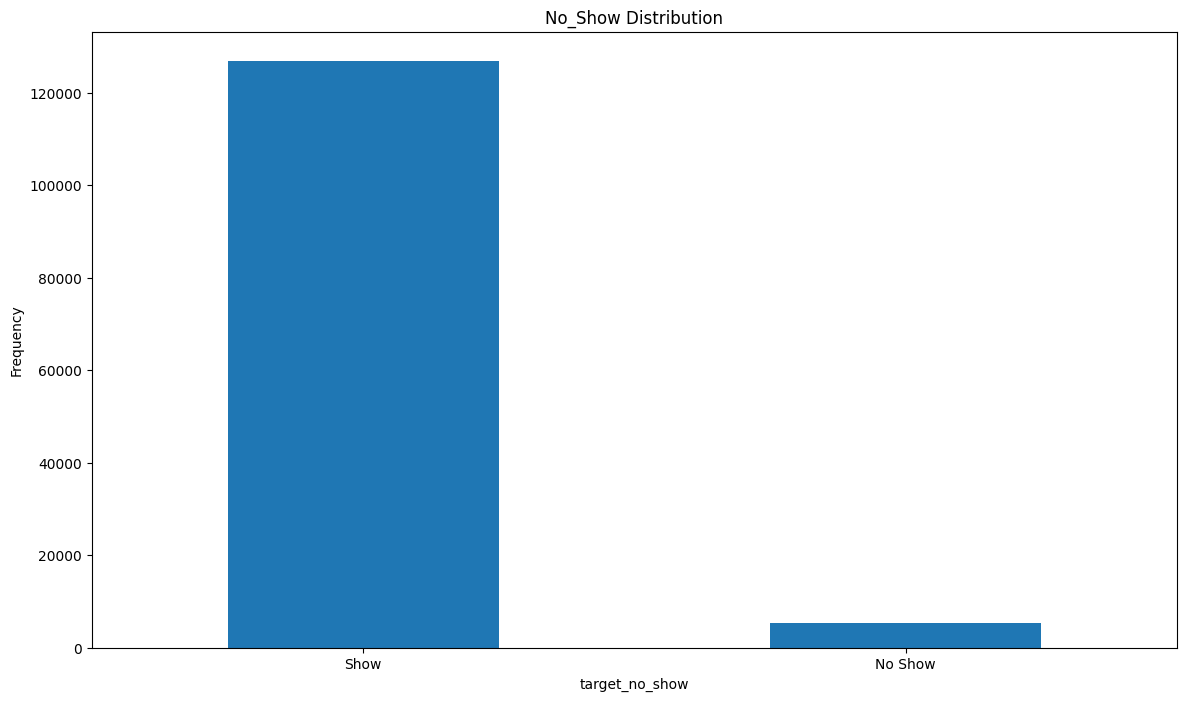

In [63]:
count_classes = pd.value_counts(data['target_no_show'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt. title("No_Show Distribution")
plt. xticks(range(2), LABELS)
plt. xlabel("target_no_show")
plt. ylabel ("Frequency")

In [33]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, Y)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Initialize Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(y_test, y_pred):
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Print the results
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Return the results in a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix
    }
# Evaluate the model
evaluate_model(y_test, y_pred)

Accuracy: 0.99
Precision: 1.00
Recall: 0.98
F1 Score: 0.99
Confusion Matrix:
[[37895    27]
 [  663 37527]]


{'accuracy': 0.9909344124448182,
 'precision': np.float64(0.9992810353091548),
 'recall': np.float64(0.9826394344069128),
 'f1': np.float64(0.9908903675538656),
 'confusion_matrix': array([[37895,    27],
        [  663, 37527]])}

In [64]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load and preprocess data (your existing preprocessing code)

# Split the data
X = data[columns]
Y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the resampled training data
rf.fit(X_train_res, y_train_res)

# Make predictions on the original test data
y_pred = rf.predict(X_test)

# Define and use evaluate_model function to print and return metrics
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix
    }

# Evaluate the model
evaluate_model(y_test, y_pred)


Accuracy: 0.98
Precision: 0.98
Recall: 0.55
F1 Score: 0.70
Confusion Matrix:
[[37977    17]
 [  754   913]]


{'accuracy': 0.9805602481026702,
 'precision': np.float64(0.9817204301075269),
 'recall': np.float64(0.5476904619076185),
 'f1': np.float64(0.7031189834424336),
 'confusion_matrix': array([[37977,    17],
        [  754,   913]])}

In [32]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
 
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
 
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
# Define labels for the target variable
LABELS = ["Show", "No Show"]

In [33]:
data = pd.read_csv('raw_data.csv')
data.dtypes

Gender                 object
Age                     int64
Alcohol_Consumption    object
Hypertension             bool
Diabetes                 bool
Appointment_Date       object
Schedule_Date          object
Clinic_Location        object
Specialty              object
Neighborhood           object
target_no_show           bool
dtype: object

In [34]:
# Convert target_no_show from bool to int
data['target_no_show'] = data['target_no_show'].astype(int)

# Check the data types again
print(data.dtypes)



Gender                 object
Age                     int64
Alcohol_Consumption    object
Hypertension             bool
Diabetes                 bool
Appointment_Date       object
Schedule_Date          object
Clinic_Location        object
Specialty              object
Neighborhood           object
target_no_show          int64
dtype: object


In [35]:
import pandas as pd

# Assuming df is your DataFrame
target_counts = data['target_no_show'].value_counts()
print(target_counts)


target_no_show
0    126852
1      5350
Name: count, dtype: int64


In [36]:
import pandas as pd

# Separate the classes
class_0 = data[data['target_no_show'] == 0]
class_1 = data[data['target_no_show'] == 1]

# Randomly select 100,000 samples to remove from class 0
class_0_to_remove = class_0.sample(n=100000, random_state=42)

# Keep the remaining samples from class 0
class_0_remaining = class_0.drop(class_0_to_remove.index)

# Concatenate the remaining class 0 samples with all class 1 samples
data_reduced = pd.concat([class_0_remaining, class_1], axis=0)

# Shuffle the resulting dataset (optional)
data_reduced = data_reduced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new class distribution
print(data_reduced['target_no_show'].value_counts())


target_no_show
0    26852
1     5350
Name: count, dtype: int64


In [37]:
# Save the reduced dataset to a new CSV file
# data_reduced.to_csv("reduced_data.csv", index=False)

# print("New CSV file 'reduced_data.csv' has been created.")


New CSV file 'reduced_data.csv' has been created.


In [38]:
data = pd.read_csv('reduced_data.csv')

In [39]:
# Create age group categories and convert to one-hot encoding
data['age_group'] = pd.cut(data['Age'], bins=[0, 30, 40, 50, 60, 100], labels=['<30', '30-40', '40-50', '50-60', '>60'])
data = pd.get_dummies(data, columns=['age_group'], drop_first=True)
data.drop('Age',axis='columns',inplace=True)

In [40]:
# Map 'Alcohol Consumption' to numeric values
mapping_dict = {'0/week': 0, '1/week': 1, '5/week': 2, '10/week': 3, '> 14/week': 4}
data['Alcohol_Consumption'] = data['Alcohol_Consumption'].map(mapping_dict)

In [41]:
# Convert 'Hypertension' and 'Diabetes' to integer
data['Hypertension'] = data['Hypertension'].astype(int)
data['Diabetes'] = data['Diabetes'].astype(int)

In [42]:
# Convert 'target_no_show' to integer
data['target_no_show'] = data['target_no_show'].astype(int)

In [43]:
# Convert date columns to datetime format and extract features
data['Appointment_Date'] = pd.to_datetime(data['Appointment_Date'])
data['Schedule_Date'] = pd.to_datetime(data['Schedule_Date'])
data['appointment_day'] = data['Appointment_Date'].dt.day
data['appointment_month'] = data['Appointment_Date'].dt.month
data['appointment_year'] = data['Appointment_Date'].dt.year
data['appointment_dayofweek'] = data['Appointment_Date'].dt.dayofweek
data['schedule_day'] = data['Schedule_Date'].dt.day
data['schedule_month'] = data['Schedule_Date'].dt.month
data['schedule_year'] = data['Schedule_Date'].dt.year
data['schedule_dayofweek'] = data['Schedule_Date'].dt.dayofweek
data['days_until_appointment'] = (data['Appointment_Date'] - data['Schedule_Date']).dt.days
 
# Drop the original date columns if they are not needed anymore
data.drop(columns=['Appointment_Date', 'Schedule_Date'], inplace=True)

In [44]:
# Apply One-Hot Encoding for nominal variables
data = pd.get_dummies(data, columns=['Clinic_Location', 'Specialty', 'Neighborhood'])

In [45]:
from sklearn.preprocessing import LabelEncoder
# Apply Label Encoding for ordinal or binary variables
label_encoders = {}
for column in ['Gender']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [46]:
# Convert all boolean columns to integers (0 and 1)
data = data.astype({col: 'int64' for col in data.select_dtypes(include='bool').columns})

# Verify the conversion
print(data.dtypes)

Gender                              int64
Alcohol_Consumption                 int64
Hypertension                        int64
Diabetes                            int64
target_no_show                      int64
                                    ...  
Neighborhood_Treasure Island/YBI    int64
Neighborhood_Twin Peaks             int64
Neighborhood_Visitacion Valley      int64
Neighborhood_West of Twin Peaks     int64
Neighborhood_Western Addition       int64
Length: 331, dtype: object


In [47]:
# Count the number of 0s and 1s in the 'target_no_show' column
value_counts = data['target_no_show'].value_counts()

# Print the counts
print(f"Number of 0s in 'target_no_show': {value_counts[0]}")
print(f"Number of 1s in 'target_no_show': {value_counts[1]}")

Number of 0s in 'target_no_show': 26852
Number of 1s in 'target_no_show': 5350


In [48]:
# Create independent and Dependent Features
columns = data.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["target_no_show"]]
# Store the variable we are predicting
target = "target_no_show"
 
# Define a random state
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(32202, 330)
(32202,)


In [49]:
# Remove rows with any missing values
data = data.dropna()

In [50]:
# Check if there are still any missing values
data.isnull().values.any()

np.False_

/var/folders/0z/lpdq6xc50fb_51rn5s1nddzh0000gn/T/ipykernel_3243/2872962731.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['target_no_show'], sort = True)


Text(0, 0.5, 'Frequency')

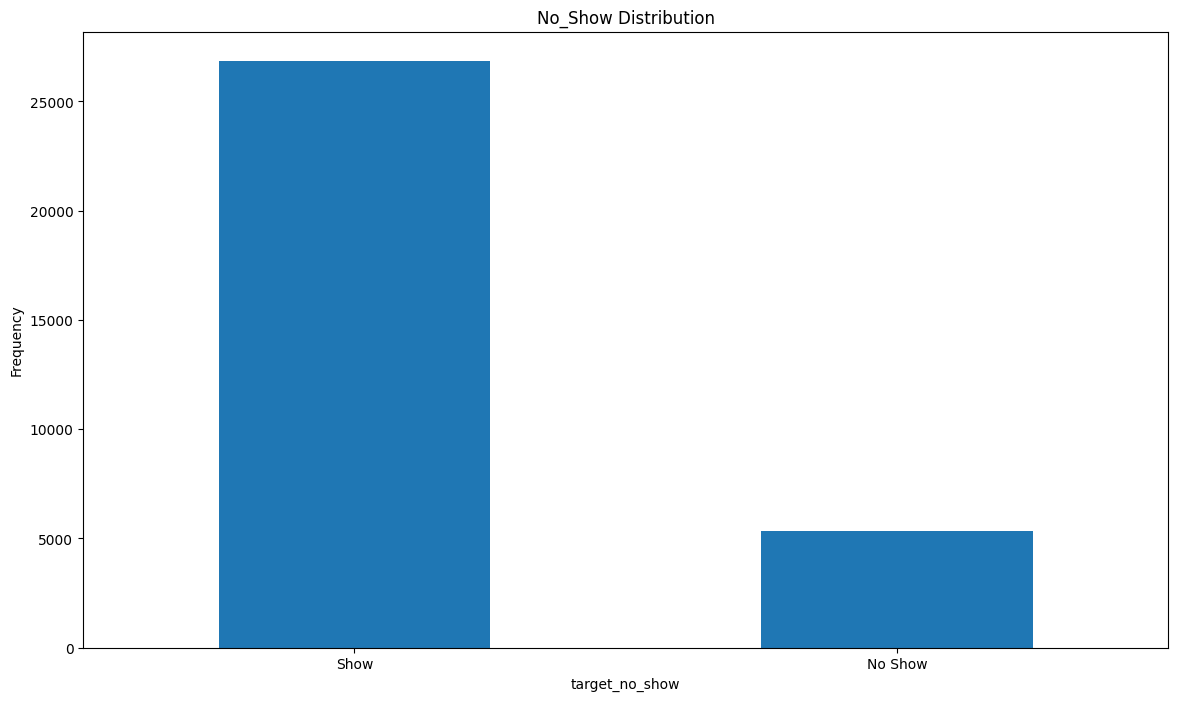

In [51]:
count_classes = pd.value_counts(data['target_no_show'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt. title("No_Show Distribution")
plt. xticks(range(2), LABELS)
plt. xlabel("target_no_show")
plt. ylabel ("Frequency")

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, Y)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Initialize Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(y_test, y_pred):
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Print the results
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Return the results in a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix
    }
# Evaluate the model
evaluate_model(y_test, y_pred)

In [ ]:
import tensorflow as tf 
from tensorflow import keras 

model = keras.Sequential([
    keras.layers.Dense(20,input_shape=(26,),activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.fit(X_train,y_train,epochs=100)

In [52]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming data is your preprocessed DataFrame
X = data.drop(columns=['target_no_show'])
y = data['target_no_show']

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Convert to TensorFlow-compatible format
X_smote = np.array(X_smote)
y_smote = np.array(y_smote)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Define a simple TensorFlow model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Predict the labels for the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculate and print classification metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Generate and print the full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=LABELS))


/Users/govindkumargupta/Documents/No_Show_MLProject/venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: object __array__ method not producing an array

In [60]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

# Load the data
data = pd.read_csv('reduced_data.csv')

# Check for and handle missing values (if any)
data = data.dropna()

# Convert 'target_no_show' from bool to int
data['target_no_show'] = data['target_no_show'].astype(int)

# Verify data types before processing
print("Initial Data Types:\n", data.dtypes)

# Create age group categories and one-hot encoding
data['age_group'] = pd.cut(data['Age'], bins=[0, 30, 40, 50, 60, 100], labels=['<30', '30-40', '40-50', '50-60', '>60'])
data = pd.get_dummies(data, columns=['age_group'], drop_first=True)
data.drop('Age', axis='columns', inplace=True)

# Map 'Alcohol Consumption' to numeric values
mapping_dict = {'0/week': 0, '1/week': 1, '5/week': 2, '10/week': 3, '> 14/week': 4}
data['Alcohol_Consumption'] = data['Alcohol_Consumption'].map(mapping_dict)

# Convert other necessary columns to integers
data['Hypertension'] = data['Hypertension'].astype(int)
data['Diabetes'] = data['Diabetes'].astype(int)

# Convert date columns to datetime format and extract features
data['Appointment_Date'] = pd.to_datetime(data['Appointment_Date'])
data['Schedule_Date'] = pd.to_datetime(data['Schedule_Date'])
data['days_until_appointment'] = (data['Appointment_Date'] - data['Schedule_Date']).dt.days

# Drop the original date columns if not needed anymore
data.drop(columns=['Appointment_Date', 'Schedule_Date'], inplace=True)

# Apply One-Hot Encoding for nominal variables
data = pd.get_dummies(data, columns=['Clinic_Location', 'Specialty', 'Neighborhood'])

# Apply Label Encoding for binary variables
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])

# Convert boolean columns to integers
bool_columns = data.select_dtypes(include=['bool']).columns
for column in bool_columns:
    data[column] = data[column].astype(int)

# Verify data types after conversion
print("\nData Types After Conversion:\n", data.dtypes)

# Ensure all data is numeric
assert data.apply(lambda x: np.issubdtype(x.dtype, np.number)).all(), "Non-numeric data found in dataset"

# Create feature and target arrays
X = data.drop(columns=['target_no_show']).values
y = data['target_no_show'].values

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Convert to TensorFlow-compatible format and ensure data type consistency
X_smote = np.array(X_smote, dtype=np.float32)
y_smote = np.array(y_smote, dtype=np.float32)

# Verify shapes and types of the arrays
print("\nShapes and Types of Arrays:")
print(f"X_smote type: {type(X_smote)}, dtype: {X_smote.dtype}, shape: {X_smote.shape}")
print(f"y_smote type: {type(y_smote)}, dtype: {y_smote.dtype}, shape: {y_smote.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Print shapes and types for debugging
print(f"\nX_train type: {type(X_train)}, dtype: {X_train.dtype}, shape: {X_train.shape}")
print(f"y_train type: {type(y_train)}, dtype: {y_train.dtype}, shape: {y_train.shape}")

# Define a simple TensorFlow model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
try:
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
except Exception as e:
    print(f"Error during model training: {e}")

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.2f}")

# Predict the labels for the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculate and print classification metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Generate and print the full classification report
LABELS = ["Show", "No Show"]
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=LABELS))


Initial Data Types:
 Gender                 object
Age                     int64
Alcohol_Consumption    object
Hypertension             bool
Diabetes                 bool
Appointment_Date       object
Schedule_Date          object
Clinic_Location        object
Specialty              object
Neighborhood           object
target_no_show          int64
dtype: object

Data Types After Conversion:
 Gender                              int64
Alcohol_Consumption                 int64
Hypertension                        int64
Diabetes                            int64
target_no_show                      int64
                                    ...  
Neighborhood_Treasure Island/YBI    int64
Neighborhood_Twin Peaks             int64
Neighborhood_Visitacion Valley      int64
Neighborhood_West of Twin Peaks     int64
Neighborhood_Western Addition       int64
Length: 323, dtype: object

Shapes and Types of Arrays:
X_smote type: <class 'numpy.ndarray'>, dtype: float32, shape: (53704, 322)
y_smote typ

/Users/govindkumargupta/Documents/No_Show_MLProject/venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: object __array__ method not producing an array